In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns

parent_path = os.path.abspath("/Users/lucasinglese/Desktop/Challenge/6. CODES/FEATURES")
sys.path.append(parent_path)
from FeaturesLibrary import *
from Signals import *
from FeaturesImportance import *
plt.style.use('seaborn')

# Data Import

In [2]:
# Import the data
eurusd = pd.read_csv("../DATA/4-hours Pepperstone/4-hours_EURUSD.csv", parse_dates=True, index_col="time").iloc[0:5000,:]
gbpusd = pd.read_csv("../DATA/4-hours Pepperstone/4-hours_GBPUSD.csv", parse_dates=True, index_col="time").iloc[0:5000,:]
usdcad = pd.read_csv("../DATA/4-hours Pepperstone/4-hours_USDCAD.csv", parse_dates=True, index_col="time").iloc[0:5000,:]
usdjpy = pd.read_csv("../DATA/4-hours Pepperstone/4-hours_USDJPY.csv", parse_dates=True, index_col="time").iloc[0:5000,:]
usdchf = pd.read_csv("../DATA/4-hours Pepperstone/4-hours_USDCHF.csv", parse_dates=True, index_col="time").iloc[0:5000,:]

# Target Engineering

In [4]:
eurusd = future_returns(eurusd,100)
gbpusd = future_returns(gbpusd,100)
usdcad = future_returns(usdcad,100)
usdjpy = future_returns(usdjpy,100)
usdchf = future_returns(usdchf,100)

# Features Engineering

Here, we need to keep in mind that we will work on a target that predict the return from now to 400h later. So, all the short term variables will just had noise in our model.

In [5]:
def create_features(df):
    df = rolling_adf(df, "close", window_size=50)
    df = kama_market_regime(df, "close", 60, 200)
    for i in [10,20,50,100,200]:
        df = log_transform(df, "close", i)
        df = auto_corr(df, f"ret_log_{i}", n=200, lag=i)
    df = moving_yang_zhang_estimator(df, 200)
    df = moving_parkinson_estimator(df,100)
    
    return df

eurusd = create_features(eurusd.iloc[:-1,:])
gbpusd = create_features(gbpusd.iloc[:-1,:])
usdcad = create_features(usdcad.iloc[:-1,:])
usdjpy = create_features(usdjpy.iloc[:-1,:])
usdchf = create_features(usdchf.iloc[:-1,:])

# Train/Test

In [49]:
eurusd_train = eurusd.iloc[:3000,:]
gbpusd_train = gbpusd.iloc[:3000,:]
usdcad_train = usdcad.iloc[:3000,:]
usdjpy_train = usdjpy.iloc[:3000,:]
usdchf_train = usdchf.iloc[:3000,:]

# Features - Target Building

In [17]:
list_X = ['ret_log_100', 'ret_log_200', 'ret_log_10',
       'ret_log_20', 'ret_log_50', 'autocorr_100',
       'autocorr_20',"autocorr_10", "kama_diff",
          "rolling_volatility_yang_zhang", "rolling_volatility_parkinson",
         "kama_trend", "rolling_adf_stat"]
col_y = "fut_ret"

# Correlation

In [18]:
# Make a copy of the dataframe and drop rows with NA values
correlations = []
assets = [eurusd_train, gbpusd_train, usdjpy_train, usdcad_train, usdchf_train]
for asset in assets:
    df_copy = asset[list_X + [col_y]].dropna()

    # Create feature matrix X and target vector y
    X = df_copy[list_X].iloc[:-1,:]
    y = df_copy[col_y].iloc[1:]

    dfc = pd.concat((X,y), axis=1)

    correlations.append(dfc.corr()[col_y])

In [19]:
correlation = pd.concat(correlations, axis=1)
correlation.columns = ["EURUSD", "GBPUSD", "USDJPY", "USDCAD", "USDCHF"]
correlation = correlation.transpose()
del correlation[col_y]
correlation = correlation.transpose()

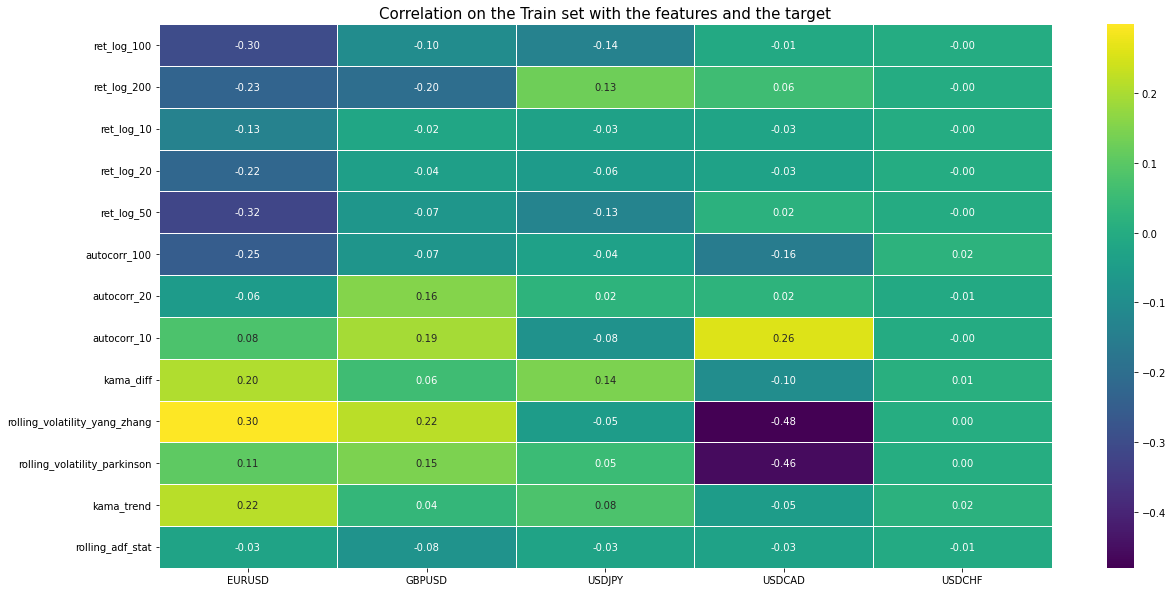

In [20]:
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='viridis', linewidths=.5)
plt.title("Correlation on the Train set with the features and the target", size=15)
plt.show()

# Features Importance

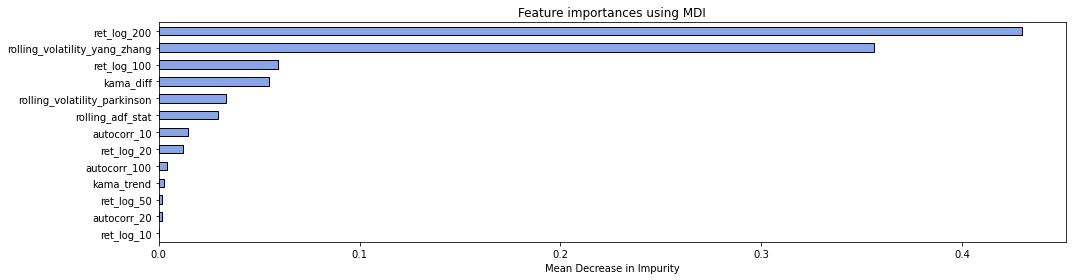

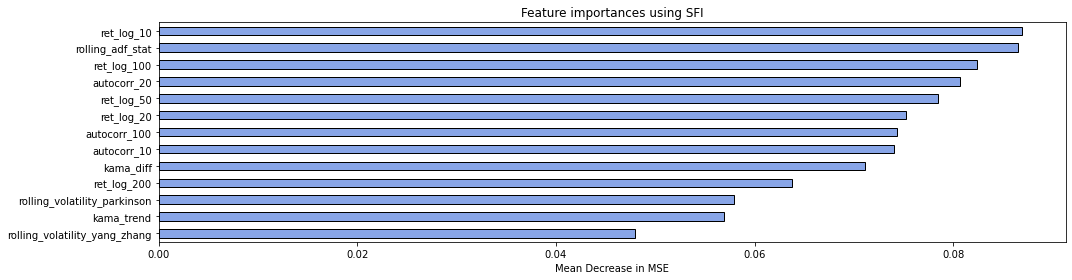

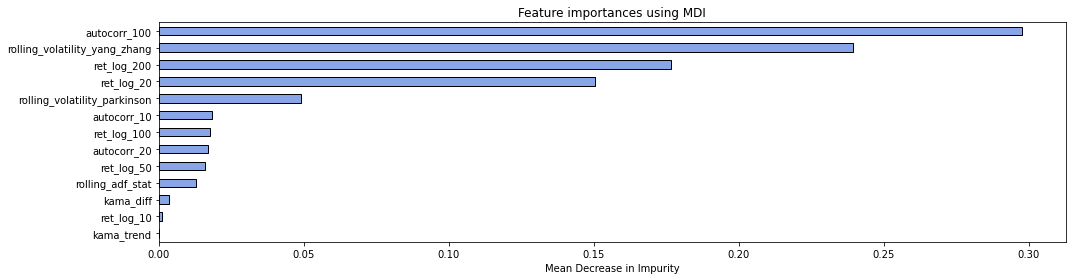

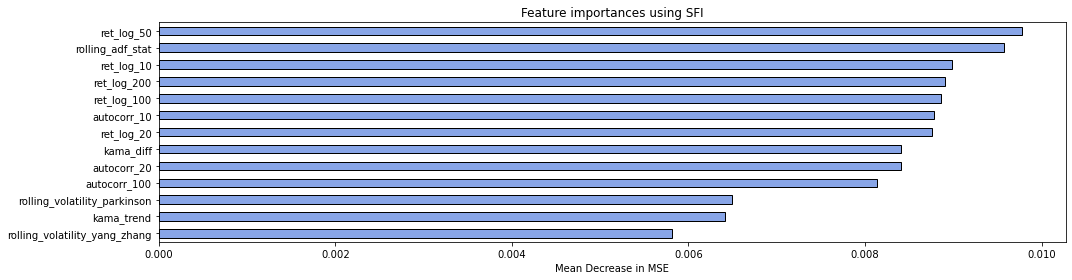

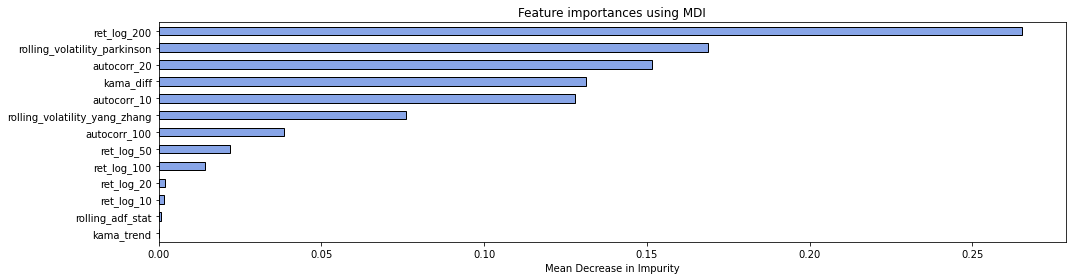

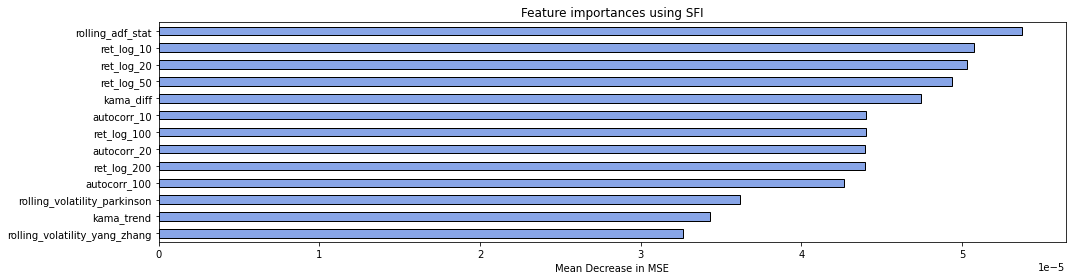

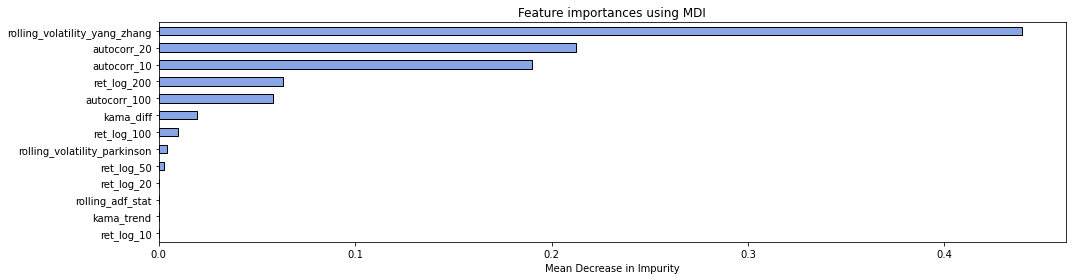

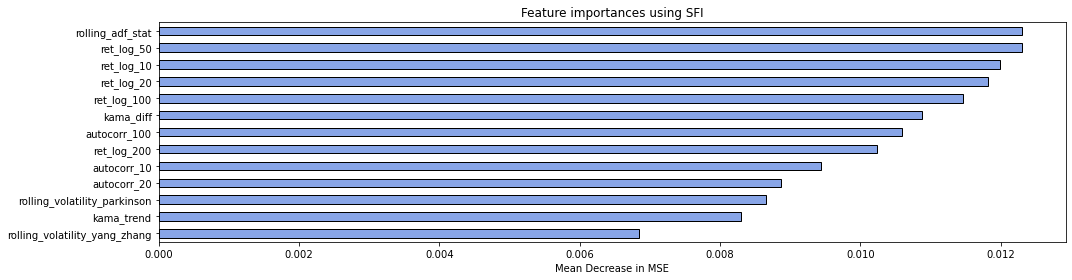

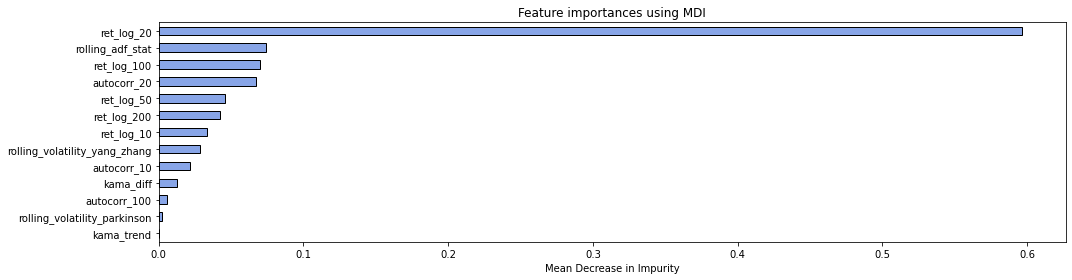

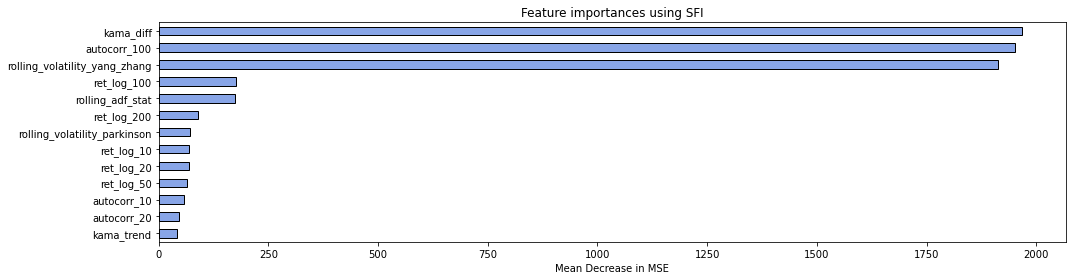

In [51]:
assets = [eurusd_train, gbpusd_train, usdjpy_train, usdcad_train, usdchf_train]
for asset in assets:
    feature_importance(asset, list_X, col_y, reg=True, mda=False)

# Model

In [74]:
df = pd.concat((eurusd_train, gbpusd_train, usdjpy_train), axis=0)
#df = usdcad_train
# Make a copy of the dataframe and drop rows with NA values
df_copy = df[list_X + [col_y]].dropna()
df_copy = df_copy[~np.isinf(df_copy).any(axis=1)]

# Create feature matrix X and target vector y
X = df_copy[list_X].iloc[:-1,:].values
y = df_copy[col_y].iloc[1:].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a RandomForest model
model = RandomForestRegressor(max_depth=3,random_state=42)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, random_state=42)

In [75]:
y_pred = model.predict(X_test)

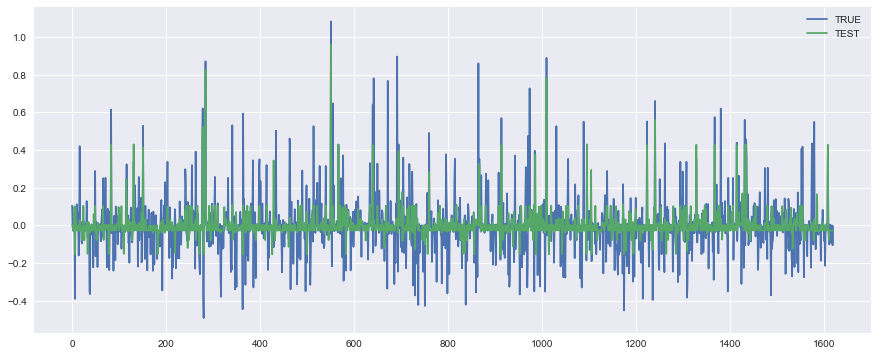

In [96]:
plt.figure(figsize=(15,6))
plt.plot(y_test, label="TRUE")
plt.plot(y_pred, label="TEST")
plt.legend()

In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
print(confusion_matrix(np.where(0<y_test, 1,0),np.where(0<y_pred, 1,0)))
print(accuracy_score(np.where(0<y_test, 1,0),np.where(0<y_pred, 1,0)))
print(f1_score(np.where(0<y_test, 1,0),np.where(0<y_pred, 1,0)))

[[565 314]
 [294 448]]
0.6249228871067243
0.5957446808510638


In [78]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

0.07706688946336655

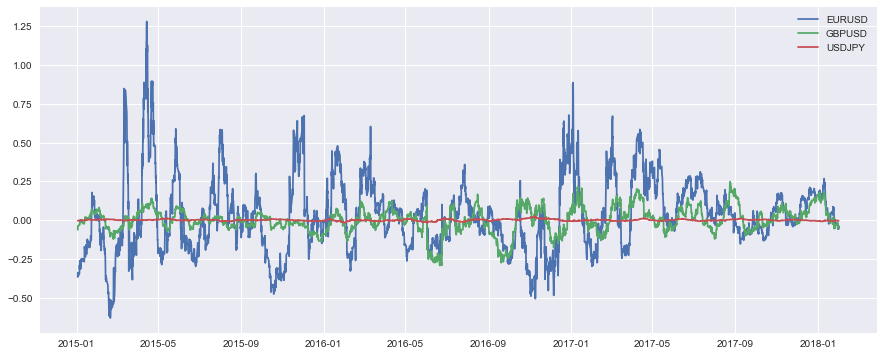

In [97]:
plt.figure(figsize=(15,6))
plt.plot(eurusd["fut_ret"], label="EURUSD")
plt.plot(gbpusd["fut_ret"], label="GBPUSD")
plt.plot(usdjpy["fut_ret"], label="USDJPY")
plt.legend()
plt.show()

# Robustness

In [79]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, TimeSeriesSplit

df = pd.concat((eurusd, gbpusd, usdjpy), axis=0)
#df = usdcad
# Make a copy of the dataframe and drop rows with NA values
df_copy = df[list_X + [col_y]].dropna()
df_copy = df_copy[~np.isinf(df_copy).any(axis=1)]

# Create feature matrix X and target vector y
X = df_copy[list_X].iloc[:-1,:].values
y = df_copy[col_y].iloc[1:].values

# Initialize classifier
clf = RandomForestRegressor(max_depth=3,random_state=42)

# K-Fold cross validation
tscv = TimeSeriesSplit(n_splits=5)
#kf = KFold(n_splits=k, shuffle=False)

# Collect scores
scores = cross_val_score(clf, X, y, cv=tscv, scoring="neg_mean_absolute_error")

print(f"Scores for each fold: {scores}")
print(f"Average Accuracy: {np.mean(scores):.2f}")
print(f"Standard Deviation: {np.std(scores):.2f}")


Scores for each fold: [-0.17260207 -0.08733549 -0.07996598 -0.01598728 -0.0139141 ]
Average Accuracy: -0.07
Standard Deviation: 0.06


# Conclusion

Good signal that will help us to detect the medium-term movement (100 next candles on the 4-hours timeframe), it should be a very good features if you work with swing trading strategies.

### How to improve this signal?
- Check the robustness about the target variation. (try from 95 to 105 candles to see if we still have good results)
- Let me know in the comment of this video if you have another idea